## SORBONNE UNIVERSITY - M2 DAC - 2023 - 2024
## RDFIA - Practical 2_A : Transfer Learning
## Implemented by: Allaa BOUTALEB (21112734) & Samy NEHLIL (21113646)

### PyTorch Lightning is used extensively in this practical, so please make sure it's installed.

In [1]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torch.utils.data import Subset
import torch.optim as optim


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import LinearSVC

# Partie 1 : Architecture VGG16

In [2]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2023-12-28 11:20:18--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl [following]
--2023-12-28 11:20:18--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: 'imagenet_classes.pkl'

     0K .......... .......... .......... ....                 100% 1.33M=0.03s

2023-12-28 11:20:18 (1.33 MB/s) - 'imagenet_classes.pkl' saved [35454/

In [3]:
import numpy as np
from PIL import Image
import torch

def image_class(model, img):
    # Define the transformation: resize, to tensor, and normalization
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply the transformations to the image
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Pass the tensor through the model to get the predicted class probabilities
    y = model(img_tensor)

    # Detach the output from the graph and convert it back to a numpy array for argmax operation
    y = y.detach().numpy()

    # Get the index of the maximum value in the predicted probabilities which corresponds to the predicted class
    return imagenet_classes[np.argmax(y)]


In [4]:
#dog = Image.open('dog.jpg')
#car = Image.open('car.jpg')
#plane = Image.open('plane.jpg')
#plt.imshow(cat)
#plt.imshow(dog)
#plt.imshow(car)
#plt.imshow(plane)


vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval()
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))

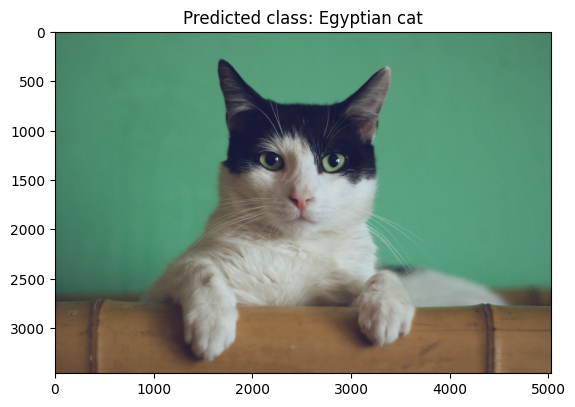

In [5]:
img = Image.open('cat.jpg')
plt.title("Predicted class: "+image_class(vgg16,img))
plt.imshow(img)

## Bonus : Testing on Other images

We will now experiment with VGG-16 on the CIFAR-10 dataset.

In [6]:
import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score
from pytorch_lightning.loggers import TensorBoardLogger


class VGG16_CIFAR10(pl.LightningModule):
    def __init__(self):
        super(VGG16_CIFAR10, self).__init__()
        self.vgg16 = torchvision.models.vgg16(pretrained=True)
        self.vgg16.classifier[6] = nn.Linear(self.vgg16.classifier[6].in_features, 10)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass',num_classes=10)
        self.f1_score = F1Score(task="multiclass", num_classes=10)

    def forward(self, x):
        return self.vgg16(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        labels_hat = self(images)
        loss = self.criterion(labels_hat, labels)
        acc = self.accuracy(labels_hat, labels)
        f1_score = self.f1_score(labels_hat, labels)
        self.log_dict(
            {
                "train_loss": loss,
                "train_accuracy": acc,
                "train_f1_score": f1_score
            },
        on_step=True,
        on_epoch=True,
        prog_bar=True,
        )
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch
        labels_hat = self(images)
        loss = self.criterion(labels_hat, labels)
        acc = self.accuracy(labels_hat, labels)
        f1_score = self.f1_score(labels_hat, labels)
        self.log_dict(
            {
                "test_loss": loss,
                "test_accuracy": acc,
                "test_f1_score": f1_score
            },
            on_step=True,
            on_epoch=True,
            prog_bar=True,
        )

    def configure_optimizers(self):
        optimizer = optim.SGD(self.vgg16.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
        return optimizer

    def train_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
        cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        return DataLoader(cifar10_train, batch_size=40, shuffle=True)
    
    def test_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
        cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        return DataLoader(cifar10_test, batch_size=40, shuffle=False)


In [7]:
from pytorch_lightning import Trainer
from lightning.pytorch.loggers import CSVLogger

model = VGG16_CIFAR10()
logger = CSVLogger("lightning_logs", name="vgg16_cifar10")
trainer = Trainer(max_epochs=5, accelerator="gpu", logger=logger)
trainer.fit(model)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | vgg16     | VGG                | 134 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
3 | f1_score  | MulticlassF1Score  | 0     
-------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.206   Total estimated model params s

100%|██████████| 170498071/170498071 [00:15<00:00, 10665709.99it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [8]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   test_accuracy_epoch      0.9251999855041504
   test_f1_score_epoch      0.9251999855041504
     test_loss_epoch        0.25938308238983154
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.25938308238983154,
  'test_accuracy_epoch': 0.9251999855041504,
  'test_f1_score_epoch': 0.9251999855041504}]

In [9]:
###### To plot the confusion matrix

all_predicted = []
all_labels = []
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(cifar10_test, batch_size=40, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    for i, (images, labels) in tqdm(enumerate(test_loader),desc="Test",unit="batch"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model.forward(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Files already downloaded and verified


Test: 250batch [00:15, 16.18batch/s]


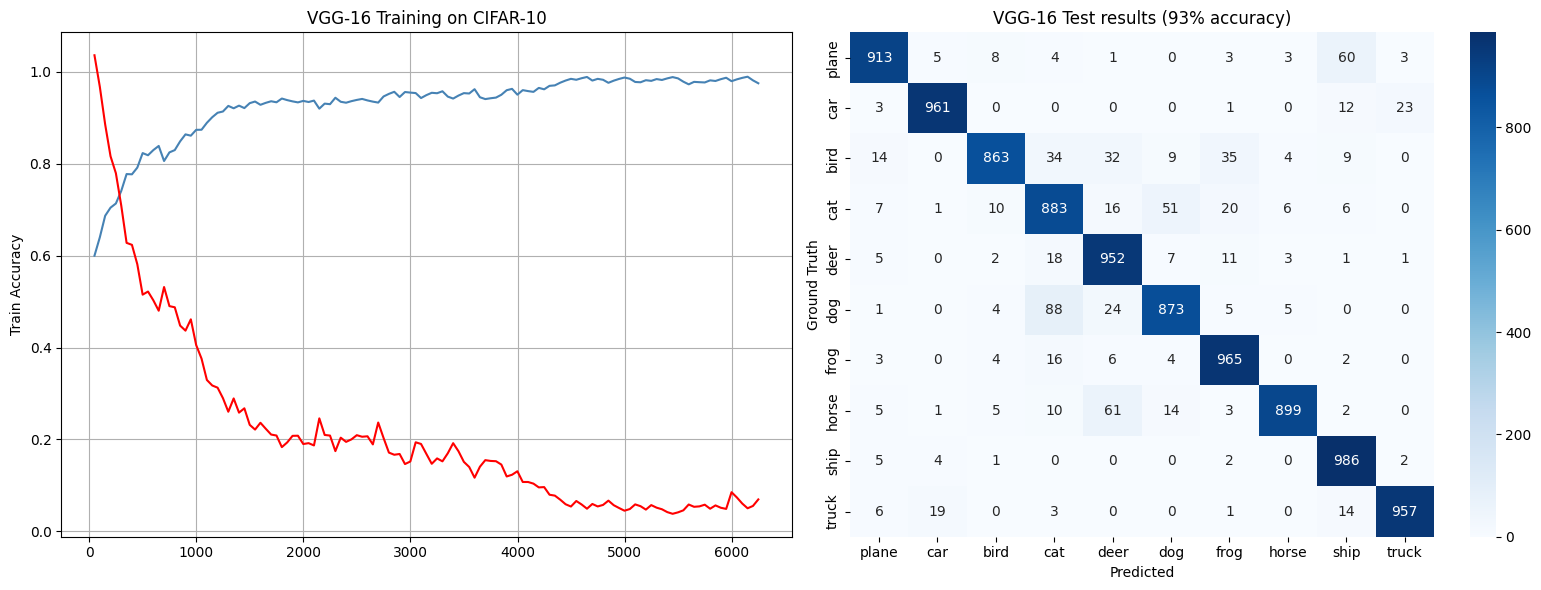

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision.transforms as transforms
from tqdm import tqdm

# Load the CSV file into a DataFrame
df = pd.read_csv('lightning_logs/vgg16_cifar10/version_0/metrics.csv').dropna(subset=['train_accuracy_step'])

# Function to smooth the curves
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smoothing the accuracy and loss data
smoothed_accuracy = smooth_curve(df['train_accuracy_step'])
smoothed_loss = smooth_curve(df['train_loss_step'])

# Create a single figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plotting Smoothed Train Accuracy per Step
ax1.plot(df['step'], smoothed_accuracy, label='Train Accuracy (per step)', color='steelblue')
ax1.plot(df['step'], smoothed_loss, label='Train Accuracy (per step)', color='red')

# Plotting Smoothed Train Loss per Step
ax1.set_ylabel('Train Accuracy')
ax1.set_title('VGG-16 Training on CIFAR-10')
ax1.grid(True)

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

# Plot the confusion matrix as a heatmap
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Ground Truth')
ax2.set_title('VGG-16 Test results (93% accuracy)')
ax2.grid(False)

# Save the combined figure as "vgg16_cifar10.pdf"
plt.tight_layout()
plt.savefig('imgs/vgg16_cifar10.pdf', format='pdf')
plt.show()


## Bonus : Visualizing activation maps

We will now go back to the original set from imagenet. 


In [12]:
dog = Image.open('dog.jpg')
cat = Image.open('cat.jpg')

# Load VGG-16 model
model = torchvision.models.vgg16(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Function to get the first convolutional layer's output
class VGG16Conv1(nn.Module):
    def __init__(self):
        super(VGG16Conv1, self).__init__()
        self.features = nn.Sequential(*list(model.features.children())[:2])

    def forward(self, x):
        return self.features(x)

# Initialize the modified model
vgg16_conv1 = VGG16Conv1()

In [13]:
# Define the function for visualization
def visualize_activation_maps(input_image,save=False, name=None):
    # Define the transformation
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Apply the transformations to the image
    img_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension

    # Load VGG-16 model and modify it
    vgg16_conv1 = VGG16Conv1()
    vgg16_conv1.eval()  # Set to evaluation mode

    # Get the activation maps
    activation_maps = vgg16_conv1(img_tensor)  # Pass the image through the model
    activation_maps = activation_maps.squeeze(0).detach().numpy()  # Convert to numpy

    # Plotting the activation maps
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(20, 4))
    for i, ax in enumerate(axes.flatten()):
        if i >= activation_maps.shape[0]:
            break
        ax.imshow(activation_maps[i], cmap='inferno')
        ax.axis('off')
        
    if save: 
        if name is not None: plt.savefig(name, format='pdf')

    plt.show()

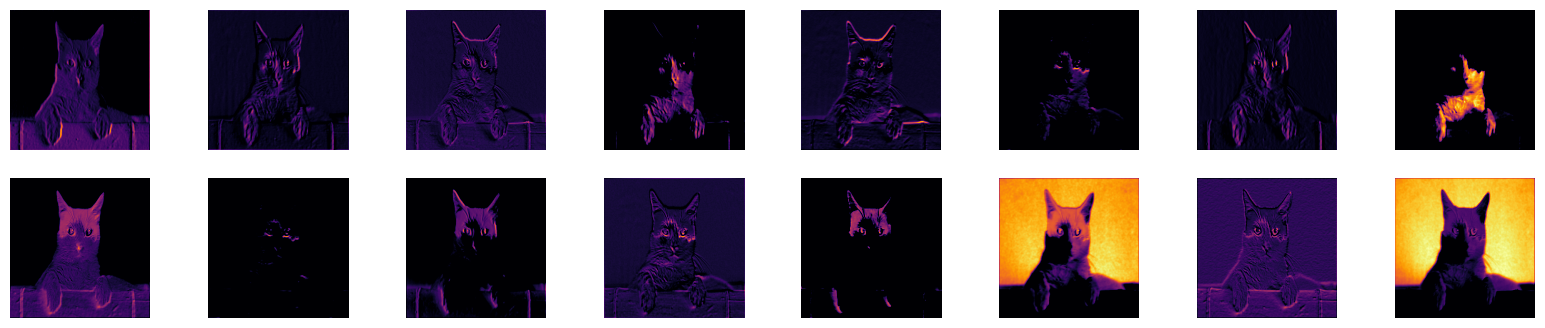

In [14]:
image_path='imgs/'
visualize_activation_maps(cat,save=True,name=image_path+'activation_map_cat.pdf')

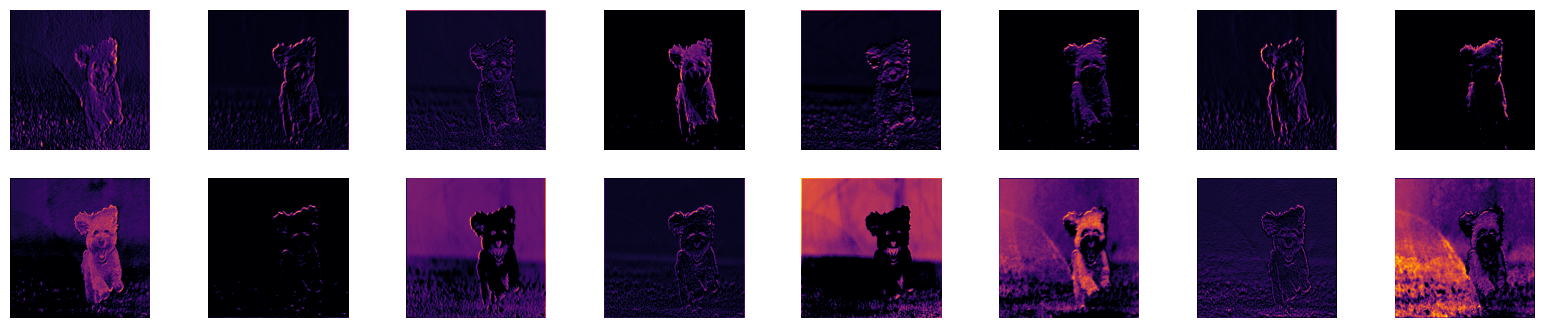

In [15]:
visualize_activation_maps(dog,save=True,name=image_path+'activation_map_dog.pdf')

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [16]:
# !wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

--2023-12-28 11:51:50--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip [following]
--2023-12-28 11:51:50--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: '15ScenesData.zip'

     0K .......... .......... .......... .......... ..........  0% 1.18M 70s
    50K .......... .......... .......... .......... ..........  0% 3.16M 48s
   1

In [17]:
PRINT_INTERVAL = 50
CUDA = torch.cuda.is_available()
def duplicateChannel(img):
    img = img.convert('RGB')
    return img

def get_dataset(batch_size, path):
    transformation = transforms.Compose([
                transforms.Resize((224,224), interpolation=Image.NEAREST),
                transforms.Lambda(duplicateChannel),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    # Ajouter le pré-traitement
    train_dataset = datasets.ImageFolder(path+'/train',transform=transformation)
    val_dataset = datasets.ImageFolder(path+'/test',transform=transformation)
    
    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=CUDA)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA)

    return train_loader, val_loader

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def extract_features(data, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize feature and label matrices
    X = torch.FloatTensor().to(device)
    y = torch.LongTensor()

    # Iterate over the data loader
    for i, (input, target) in tqdm(enumerate(data),desc="Feature extraction",unit=" batches"):
        
        # If using CUDA, transfer input to GPU
        if CUDA: input = input.cuda()
        
        # Feature extraction
        features = model(input)
        
        # Concatenate the batch features to the features matrix X
        X = torch.cat((X, features))
        
        # Concatenate the target labels to the labels matrix y
        y = torch.cat((y, target))

    return X, y


def main(path="data/15SceneData", batch_size=8, feature=None, classif=-2):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    
    class VGG16_truncated(nn.Module):
        def __init__(self, feature_trunc, classif_trunc):
            super(VGG16_truncated, self).__init__()
            original_vgg16 = models.vgg16(pretrained=True)
            
            # Truncate features
            if feature_trunc is None:
                self.features = nn.Sequential(*list(original_vgg16.features.children()))
                print(f"############## Last features layer index: {len(original_vgg16.features) - 1}, Layer: {original_vgg16.features[-1]}")
            else:
                self.features = nn.Sequential(*list(original_vgg16.features.children())[:feature_trunc])
                print(f"############## Last features layer index: {len(original_vgg16.features) + feature_trunc - 1}, Layer: {list(original_vgg16.features.children())[feature_trunc - 1]}")

            self.avgpool = original_vgg16.avgpool

            # Truncate classifier
            if classif_trunc is None:
                self.classifier = nn.Sequential(*list(original_vgg16.classifier.children()))
                print(f"############## Last classifier layer index: {len(original_vgg16.features) + len(original_vgg16.classifier) - 1}, Layer: {original_vgg16.classifier[-1]}")
            else:
                self.classifier = nn.Sequential(*list(original_vgg16.classifier.children())[:classif_trunc])
                classifier_last_index = len(original_vgg16.features)+ len(original_vgg16.classifier) + classif_trunc - 1
                print(f"############## Last classifier layer index: {classifier_last_index}, Layer: {list(original_vgg16.classifier.children())[classif_trunc - 1]}")


            
        def forward(self, x):
            x = self.features(x)
            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            return x
        
    # Instantiate the modified model
    model = VGG16_truncated(feature_trunc=feature, classif_trunc=classif)

    model.eval()
    if CUDA: # if CUDA, move model to GPU
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    with torch.no_grad():
      print("Train extract: ")
      X_train, y_train = extract_features(train, model)
      print("Test extract: ")
      X_test, y_test = extract_features(test, model)
      print("\n")

    
    return X_train, X_test, y_train, y_test

In [20]:
X_train, X_test, y_train, y_test = main("data/15SceneData")

# Move tensors to CPU and convert to NumPy arrays
X_train = X_train.cpu().numpy()
y_train = y_train.cpu().numpy()
X_test = X_test.cpu().numpy()
y_test = y_test.cpu().numpy()

# Initialize the LinearSVC with C=1.0
svm = LinearSVC(C=1.0)

# Train the SVM classifier on the training data
svm.fit(X_train, y_train)

# Evaluate the classifier on the test data
accuracy = svm.score(X_test, y_test)

# Print the accuracy
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')


Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 30, Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 103.29 batches/s]


Test extract: 


Feature extraction: 374 batches [00:03, 119.71 batches/s]




Accuracy on the test set: 88.51%


# Going Further

## Expirimenting with different cutoffs in VGG

In [ ]:
# import torchvision.models as models

# vgg16 = models.vgg16(pretrained=True)

# print("Features (Convolutional layers):")
# for i, layer in enumerate(vgg16.features):
#     print(f"{i}: {layer}")

# print("\nClassifier (Fully Connected layers):")
# for i, layer in enumerate(vgg16.classifier):
#     print(f"{i+len(vgg16.features)}: {layer}")

In [21]:
feature_cuts = [-i for i in range(1, 14)]
classifier_cuts = [-i for i in range(1, 7)]

accuracies = {}

for f_cut in feature_cuts:
    accuracies[f_cut] = {}
    for c_cut in classifier_cuts:
        X_train, X_test, y_train, y_test = main("data/15SceneData", 8, feature=f_cut, classif=c_cut)

        # Convert tensors to NumPy arrays
        X_train_np = X_train.cpu().numpy()
        y_train_np = y_train.cpu().numpy()
        X_test_np = X_test.cpu().numpy()
        y_test_np = y_test.cpu().numpy()

        # Train and evaluate the SVM
        svm = LinearSVC(C=0.01)
        svm.fit(X_train_np, y_train_np)
        accuracy = svm.score(X_test_np, y_test_np)

        # Store the accuracy
        accuracies[f_cut][c_cut] = accuracy * 100

        print(f"Feature cut {f_cut}, Classifier cut {c_cut}, Accuracy: {accuracy * 100:.2f}%")


Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 29, Layer: ReLU(inplace=True)
############## Last classifier layer index: 36, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 105.62 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 126.78 batches/s]




Feature cut -1, Classifier cut -1, Accuracy: 89.05%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 29, Layer: ReLU(inplace=True)
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 123.43 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 126.34 batches/s]




Feature cut -1, Classifier cut -2, Accuracy: 89.05%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 29, Layer: ReLU(inplace=True)
############## Last classifier layer index: 34, Layer: Linear(in_features=4096, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 124.47 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 129.27 batches/s]




Feature cut -1, Classifier cut -3, Accuracy: 87.37%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 29, Layer: ReLU(inplace=True)
############## Last classifier layer index: 33, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 109.93 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.23 batches/s]




Feature cut -1, Classifier cut -4, Accuracy: 90.15%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 29, Layer: ReLU(inplace=True)
############## Last classifier layer index: 32, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 124.41 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.19 batches/s]




Feature cut -1, Classifier cut -5, Accuracy: 90.15%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 29, Layer: ReLU(inplace=True)
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 126.13 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.70 batches/s]




Feature cut -1, Classifier cut -6, Accuracy: 89.61%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 28, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 36, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 113.08 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 128.81 batches/s]




Feature cut -2, Classifier cut -1, Accuracy: 70.92%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 28, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 124.64 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.06 batches/s]




Feature cut -2, Classifier cut -2, Accuracy: 70.92%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 28, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 34, Layer: Linear(in_features=4096, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 123.46 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.55 batches/s]




Feature cut -2, Classifier cut -3, Accuracy: 87.24%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 28, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 33, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 125.16 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.04 batches/s]




Feature cut -2, Classifier cut -4, Accuracy: 88.88%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 28, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 32, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 126.00 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.78 batches/s]




Feature cut -2, Classifier cut -5, Accuracy: 88.84%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 28, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 119.68 batches/s]


Test extract: 


Feature extraction: 374 batches [00:03, 115.42 batches/s]




Feature cut -2, Classifier cut -6, Accuracy: 88.64%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 27, Layer: ReLU(inplace=True)
############## Last classifier layer index: 36, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 108.43 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 129.71 batches/s]




Feature cut -3, Classifier cut -1, Accuracy: 85.90%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 27, Layer: ReLU(inplace=True)
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 114.02 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 129.17 batches/s]




Feature cut -3, Classifier cut -2, Accuracy: 85.90%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 27, Layer: ReLU(inplace=True)
############## Last classifier layer index: 34, Layer: Linear(in_features=4096, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 114.23 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.11 batches/s]




Feature cut -3, Classifier cut -3, Accuracy: 85.39%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 27, Layer: ReLU(inplace=True)
############## Last classifier layer index: 33, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 113.00 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.31 batches/s]




Feature cut -3, Classifier cut -4, Accuracy: 87.40%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 27, Layer: ReLU(inplace=True)
############## Last classifier layer index: 32, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 125.96 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 129.83 batches/s]




Feature cut -3, Classifier cut -5, Accuracy: 87.40%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 27, Layer: ReLU(inplace=True)
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 125.25 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.07 batches/s]




Feature cut -3, Classifier cut -6, Accuracy: 89.78%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 26, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 36, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 124.61 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 129.70 batches/s]




Feature cut -4, Classifier cut -1, Accuracy: 66.37%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 26, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 126.02 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 129.83 batches/s]




Feature cut -4, Classifier cut -2, Accuracy: 66.37%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 26, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 34, Layer: Linear(in_features=4096, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 124.71 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.09 batches/s]




Feature cut -4, Classifier cut -3, Accuracy: 83.65%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 26, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 33, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 101.25 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 129.33 batches/s]




Feature cut -4, Classifier cut -4, Accuracy: 89.61%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 26, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 32, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 107.94 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.72 batches/s]




Feature cut -4, Classifier cut -5, Accuracy: 89.55%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 26, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 106.85 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.75 batches/s]




Feature cut -4, Classifier cut -6, Accuracy: 89.65%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 25, Layer: ReLU(inplace=True)
############## Last classifier layer index: 36, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 123.57 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.85 batches/s]




Feature cut -5, Classifier cut -1, Accuracy: 86.97%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 25, Layer: ReLU(inplace=True)
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 118.16 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.11 batches/s]




Feature cut -5, Classifier cut -2, Accuracy: 86.97%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 25, Layer: ReLU(inplace=True)
############## Last classifier layer index: 34, Layer: Linear(in_features=4096, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 116.19 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.85 batches/s]




Feature cut -5, Classifier cut -3, Accuracy: 86.16%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 25, Layer: ReLU(inplace=True)
############## Last classifier layer index: 33, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 119.68 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 131.47 batches/s]




Feature cut -5, Classifier cut -4, Accuracy: 86.67%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 25, Layer: ReLU(inplace=True)
############## Last classifier layer index: 32, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 126.95 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 131.20 batches/s]




Feature cut -5, Classifier cut -5, Accuracy: 86.67%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 25, Layer: ReLU(inplace=True)
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 127.02 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 131.68 batches/s]




Feature cut -5, Classifier cut -6, Accuracy: 90.55%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 24, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 36, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 104.50 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 129.63 batches/s]




Feature cut -6, Classifier cut -1, Accuracy: 68.24%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 24, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 126.28 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 129.80 batches/s]




Feature cut -6, Classifier cut -2, Accuracy: 68.24%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 24, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 34, Layer: Linear(in_features=4096, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 125.89 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 131.36 batches/s]




Feature cut -6, Classifier cut -3, Accuracy: 85.96%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 24, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 33, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 125.85 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 130.51 batches/s]




Feature cut -6, Classifier cut -4, Accuracy: 89.48%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 24, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 32, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 124.00 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 131.49 batches/s]




Feature cut -6, Classifier cut -5, Accuracy: 89.61%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 24, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 106.77 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 131.34 batches/s]




Feature cut -6, Classifier cut -6, Accuracy: 89.55%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 23, Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
############## Last classifier layer index: 36, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 128.37 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.37 batches/s]




Feature cut -7, Classifier cut -1, Accuracy: 85.43%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 23, Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 112.50 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 131.82 batches/s]




Feature cut -7, Classifier cut -2, Accuracy: 85.43%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 23, Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
############## Last classifier layer index: 34, Layer: Linear(in_features=4096, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 119.92 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 131.79 batches/s]




Feature cut -7, Classifier cut -3, Accuracy: 84.42%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 23, Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
############## Last classifier layer index: 33, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 128.50 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.59 batches/s]




Feature cut -7, Classifier cut -4, Accuracy: 85.36%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 23, Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
############## Last classifier layer index: 32, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 127.93 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 134.12 batches/s]




Feature cut -7, Classifier cut -5, Accuracy: 85.36%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 23, Layer: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 128.29 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.75 batches/s]




Feature cut -7, Classifier cut -6, Accuracy: 89.25%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 22, Layer: ReLU(inplace=True)
############## Last classifier layer index: 36, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 128.38 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 132.32 batches/s]




Feature cut -8, Classifier cut -1, Accuracy: 85.90%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 22, Layer: ReLU(inplace=True)
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 114.53 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.07 batches/s]




Feature cut -8, Classifier cut -2, Accuracy: 85.90%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 22, Layer: ReLU(inplace=True)
############## Last classifier layer index: 34, Layer: Linear(in_features=4096, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 126.12 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.44 batches/s]




Feature cut -8, Classifier cut -3, Accuracy: 84.89%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 22, Layer: ReLU(inplace=True)
############## Last classifier layer index: 33, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 111.94 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.61 batches/s]




Feature cut -8, Classifier cut -4, Accuracy: 86.70%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 22, Layer: ReLU(inplace=True)
############## Last classifier layer index: 32, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 127.46 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.90 batches/s]




Feature cut -8, Classifier cut -5, Accuracy: 86.70%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 22, Layer: ReLU(inplace=True)
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 128.80 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 134.31 batches/s]




Feature cut -8, Classifier cut -6, Accuracy: 89.61%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 21, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 36, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 109.48 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.22 batches/s]




Feature cut -9, Classifier cut -1, Accuracy: 60.17%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 21, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 124.74 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.40 batches/s]




Feature cut -9, Classifier cut -2, Accuracy: 60.13%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 21, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 34, Layer: Linear(in_features=4096, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 127.68 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.41 batches/s]




Feature cut -9, Classifier cut -3, Accuracy: 79.93%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 21, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 33, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 109.90 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 132.40 batches/s]




Feature cut -9, Classifier cut -4, Accuracy: 88.64%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 21, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 32, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 105.98 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.59 batches/s]




Feature cut -9, Classifier cut -5, Accuracy: 89.08%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 21, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 108.24 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 132.47 batches/s]




Feature cut -9, Classifier cut -6, Accuracy: 88.68%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 20, Layer: ReLU(inplace=True)
############## Last classifier layer index: 36, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 105.92 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.27 batches/s]




Feature cut -10, Classifier cut -1, Accuracy: 84.29%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 20, Layer: ReLU(inplace=True)
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 119.37 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 132.73 batches/s]




Feature cut -10, Classifier cut -2, Accuracy: 84.29%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 20, Layer: ReLU(inplace=True)
############## Last classifier layer index: 34, Layer: Linear(in_features=4096, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 117.33 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.55 batches/s]




Feature cut -10, Classifier cut -3, Accuracy: 83.95%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 20, Layer: ReLU(inplace=True)
############## Last classifier layer index: 33, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 114.15 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.17 batches/s]




Feature cut -10, Classifier cut -4, Accuracy: 84.49%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 20, Layer: ReLU(inplace=True)
############## Last classifier layer index: 32, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 126.60 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 131.62 batches/s]




Feature cut -10, Classifier cut -5, Accuracy: 84.49%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 20, Layer: ReLU(inplace=True)
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 128.12 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 132.51 batches/s]




Feature cut -10, Classifier cut -6, Accuracy: 89.28%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 19, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 36, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 106.63 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 132.06 batches/s]




Feature cut -11, Classifier cut -1, Accuracy: 65.03%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 19, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 128.88 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.29 batches/s]




Feature cut -11, Classifier cut -2, Accuracy: 65.06%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 19, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 34, Layer: Linear(in_features=4096, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 127.25 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 132.73 batches/s]




Feature cut -11, Classifier cut -3, Accuracy: 79.40%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 19, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 33, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 103.61 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 133.57 batches/s]




Feature cut -11, Classifier cut -4, Accuracy: 88.41%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 19, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 32, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 66.73 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 76.63 batches/s]




Feature cut -11, Classifier cut -5, Accuracy: 88.27%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 19, Layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 65.19 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 76.30 batches/s]




Feature cut -11, Classifier cut -6, Accuracy: 88.21%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 18, Layer: ReLU(inplace=True)
############## Last classifier layer index: 36, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 74.37 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 76.23 batches/s]




Feature cut -12, Classifier cut -1, Accuracy: 81.17%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 18, Layer: ReLU(inplace=True)
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 67.93 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 76.55 batches/s]




Feature cut -12, Classifier cut -2, Accuracy: 81.17%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 18, Layer: ReLU(inplace=True)
############## Last classifier layer index: 34, Layer: Linear(in_features=4096, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 68.88 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 76.39 batches/s]




Feature cut -12, Classifier cut -3, Accuracy: 80.87%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 18, Layer: ReLU(inplace=True)
############## Last classifier layer index: 33, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 69.07 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 77.70 batches/s]




Feature cut -12, Classifier cut -4, Accuracy: 81.11%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 18, Layer: ReLU(inplace=True)
############## Last classifier layer index: 32, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 74.65 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 77.74 batches/s]




Feature cut -12, Classifier cut -5, Accuracy: 81.11%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 18, Layer: ReLU(inplace=True)
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 74.64 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 77.60 batches/s]




Feature cut -12, Classifier cut -6, Accuracy: 88.88%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 17, Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 36, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 68.87 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 76.73 batches/s]




Feature cut -13, Classifier cut -1, Accuracy: 65.46%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 17, Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 35, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 74.34 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 76.89 batches/s]




Feature cut -13, Classifier cut -2, Accuracy: 65.43%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 17, Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 34, Layer: Linear(in_features=4096, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 73.20 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 77.59 batches/s]




Feature cut -13, Classifier cut -3, Accuracy: 79.30%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 17, Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 33, Layer: Dropout(p=0.5, inplace=False)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 67.50 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 76.97 batches/s]




Feature cut -13, Classifier cut -4, Accuracy: 86.40%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 17, Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 32, Layer: ReLU(inplace=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 68.19 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 77.57 batches/s]




Feature cut -13, Classifier cut -5, Accuracy: 86.23%
Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 17, Layer: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:02, 69.72 batches/s]


Test extract: 


Feature extraction: 374 batches [00:04, 78.08 batches/s]




Feature cut -13, Classifier cut -6, Accuracy: 86.30%


In [22]:
classif_layers = ['Dropout 2', 'ReLU 7', 'Linear 2', 'Dropout 1','ReLU 6', 'Linear 1']
feature_layers = ['ReLU 5_3', 'Conv2D 5_3', 'ReLU 5_2', 'Conv2D 5_2', 'ReLU 5_1', 'Conv2D 5_1',
                  'Maxpool2D 4', 'ReLU 4_3', 'Conv2D 4_3', 'ReLU 4_2', 'Conv2D 4_2', 'ReLU 4_1',
                  'Conv2D 4_1']

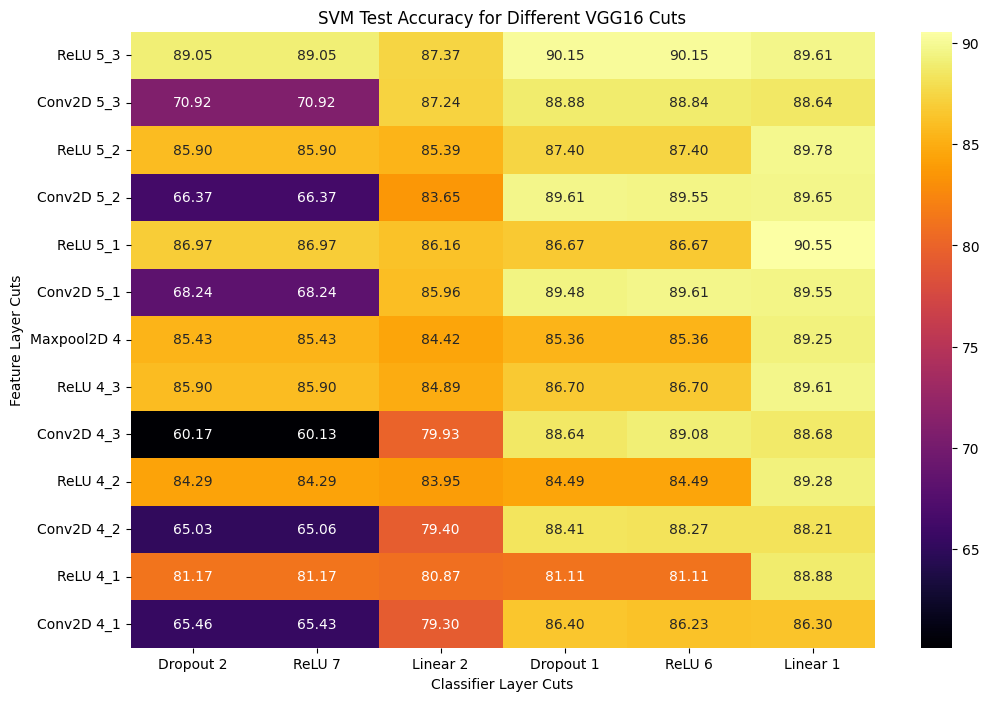

In [23]:
import pandas as pd
# Convert the accuracies dictionary to a DataFrame for easier plotting
df_accuracies = pd.DataFrame(accuracies).T  # Transpose for better layout in heatmap
df = df_accuracies
df.columns = classif_layers
df.index = feature_layers

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_accuracies, annot=True, cmap="inferno", fmt=".2f")
plt.title("SVM Test Accuracy for Different VGG16 Cuts")
plt.xlabel("Classifier Layer Cuts")
plt.ylabel("Feature Layer Cuts")
plt.savefig('imgs/different_cuts.pdf', format='pdf')
plt.show()


In [24]:
# Optimal combination
X_train, X_test, y_train, y_test = main("data/15SceneData", 8, feature=-5, classif=-6)

# Convert tensors to NumPy arrays
X_train_np = X_train.cpu().numpy()
y_train_np = y_train.cpu().numpy()
X_test_np = X_test.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Train and evaluate the SVM
svm = LinearSVC(C=0.01)
svm.fit(X_train_np, y_train_np)
accuracy = svm.score(X_test_np, y_test_np)

print(f"Accuracy: {accuracy * 100:.2f}%")


Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 25, Layer: ReLU(inplace=True)
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 99.53 batches/s] 


Test extract: 


Feature extraction: 374 batches [00:02, 125.80 batches/s]




Accuracy: 90.55%


## Tuning SVM 'C' parameter for best results

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = main("data/15SceneData", 8, feature=-5, classif=-6)

# Convert tensors to NumPy arrays
X_train = X_train.cpu().numpy()
y_train = y_train.cpu().numpy()
X_test = X_test.cpu().numpy()
y_test = y_test.cpu().numpy()

param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1]} 

grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)
best_c = grid_search.best_params_['C']
best_score = grid_search.best_score_

print(f"Best C: {best_c}")
print(f"Best cross-validation score: {best_score:.2f}%")

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f'Accuracy on the test set with best C: {test_accuracy * 100:.2f}%')


Instanciation de VGG16
Instanciation de VGG16relu7
############## Last features layer index: 25, Layer: ReLU(inplace=True)
############## Last classifier layer index: 31, Layer: Linear(in_features=25088, out_features=4096, bias=True)
Récupération des données
Feature extraction
Train extract: 


Feature extraction: 188 batches [00:01, 113.70 batches/s]


Test extract: 


Feature extraction: 374 batches [00:02, 126.31 batches/s]




Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...........................................C=0.0001; total time=   3.4s
[CV] END ...........................................C=0.0001; total time=   3.4s
[CV] END ...........................................C=0.0001; total time=   3.3s
[CV] END ...........................................C=0.0001; total time=   3.0s
[CV] END ...........................................C=0.0001; total time=   3.1s
[CV] END ............................................C=0.001; total time=   5.9s
[CV] END ............................................C=0.001; total time=  11.1s
[CV] END ............................................C=0.001; total time=  10.2s
[CV] END ............................................C=0.001; total time=  10.2s
[CV] END ............................................C=0.001; total time=  12.0s
[CV] END .............................................C=0.01; total time=  11.0s
[CV] END ......................................

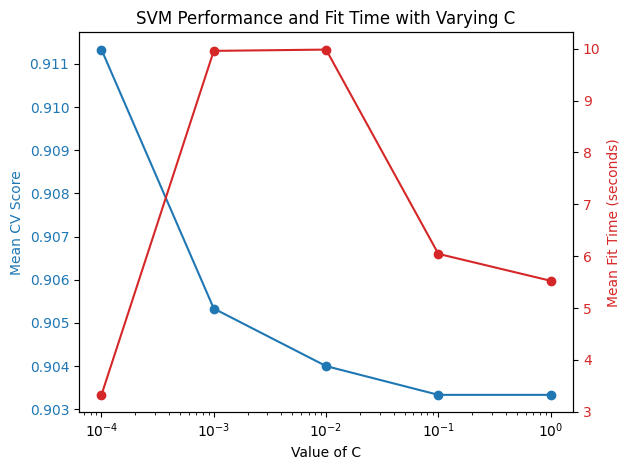

In [27]:
import matplotlib.pyplot as plt

# Extract mean test scores
mean_test_scores = grid_search.cv_results_['mean_test_score']
mean_fit_times = grid_search.cv_results_['mean_fit_time']

fig, ax1 = plt.subplots()

# Plotting mean test scores
color = 'tab:blue'
ax1.set_xlabel('Value of C')
ax1.set_ylabel('Mean CV Score', color=color)
ax1.plot(param_grid['C'], mean_test_scores, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')  # Log scale for x-axis

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Mean Fit Time (seconds)', color=color)  
ax2.plot(param_grid['C'], mean_fit_times, marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('SVM Performance and Fit Time with Varying C')
fig.tight_layout()
plt.savefig('imgs/C_param_without_dim_reduction.pdf', format='pdf')
plt.show()



### Testing the effects of Dimensionality Reduction while optimizing the C value

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...........................................C=0.0001; total time=   0.6s
[CV] END ...........................................C=0.0001; total time=   0.6s
[CV] END ...........................................C=0.0001; total time=   0.5s
[CV] END ...........................................C=0.0001; total time=   0.6s
[CV] END ...........................................C=0.0001; total time=   0.6s
[CV] END ............................................C=0.001; total time=   4.0s
[CV] END ............................................C=0.001; total time=   4.0s
[CV] END ............................................C=0.001; total time=   4.1s
[CV] END ............................................C=0.001; total time=   4.1s
[CV] END ............................................C=0.001; total time=   4.1s
[CV] END .............................................C=0.01; total time=   2.8s
[CV] END ........................................

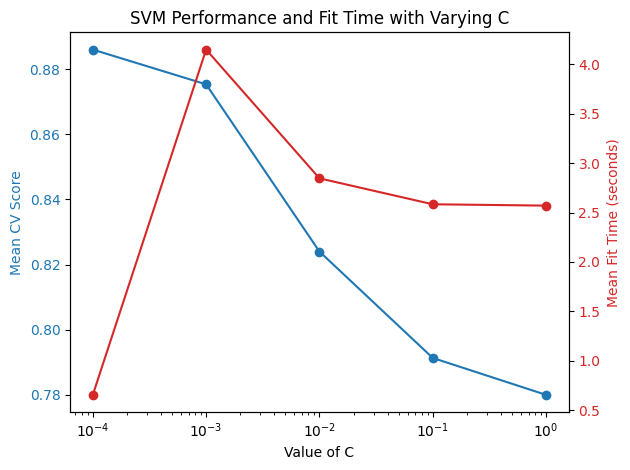

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Preserves 95% of variance

# Fit PCA on the training data and transform the training data
X_train_pca = pca.fit_transform(X_train)

# Transform the test data using the same PCA model
X_test_pca = pca.transform(X_test)

grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5, verbose=2)
grid_search.fit(X_train_pca, y_train)

best_c = grid_search.best_params_['C']
best_score = grid_search.best_score_
print(f"Best C: {best_c}")
print(f"Best cross-validation score: {best_score:.2f}%")

best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_pca, y_test)
print(f'Accuracy on the test set with best C: {test_accuracy * 100:.2f}%')

# Extract mean test scores
mean_test_scores = grid_search.cv_results_['mean_test_score']
mean_fit_times = grid_search.cv_results_['mean_fit_time']

fig, ax1 = plt.subplots()

# Plotting mean test scores
color = 'tab:blue'
ax1.set_xlabel('Value of C')
ax1.set_ylabel('Mean CV Score', color=color)
ax1.plot(param_grid['C'], mean_test_scores, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')  # Log scale for x-axis

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Mean Fit Time (seconds)', color=color)  
ax2.plot(param_grid['C'], mean_fit_times, marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('SVM Performance and Fit Time with Varying C')
fig.tight_layout()
plt.savefig('imgs/C_param_with_dim_reduction.pdf', format='pdf')
plt.show()



## Data Augmentation with VGG-16 on Scene-15

In [29]:
path = 'data/15SceneData/'
bsize = 8
torch.set_float32_matmul_precision('high') 


### VGG-16 fitted on 15 Scene

In [30]:
CUDA = torch.cuda.is_available()

class VGG16_SCENE15(pl.LightningModule):
    def __init__(self):
        super(VGG16_SCENE15, self).__init__()
        self.vgg16 = torchvision.models.vgg16(pretrained=True)
        self.vgg16.classifier[6] = nn.Linear(self.vgg16.classifier[6].in_features, 15)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass',num_classes=15)
           
    def forward(self, x):
        return self.vgg16(x)


    def common_step(self, batch, batch_idx):
        images, labels = batch
        labels_hat = self(images)
        loss = self.criterion(labels_hat, labels)
        acc = self.accuracy(labels_hat, labels)
        return loss, acc, labels_hat
    
            
    def training_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "train_loss": loss,
                "train_accuracy": acc,
            },
        on_step=False,
        on_epoch=True,
        prog_bar=True,
        )
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "val_loss": loss,
                "val_accuracy": acc,
            },
        on_step=False,
        on_epoch=True,
        prog_bar=True,
        )
        
    
    def test_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "test_loss": loss,
                "test_accuracy": acc,
            },
            prog_bar=True,
        )
        

    def configure_optimizers(self):
        optimizer = optim.SGD(self.vgg16.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
        return optimizer


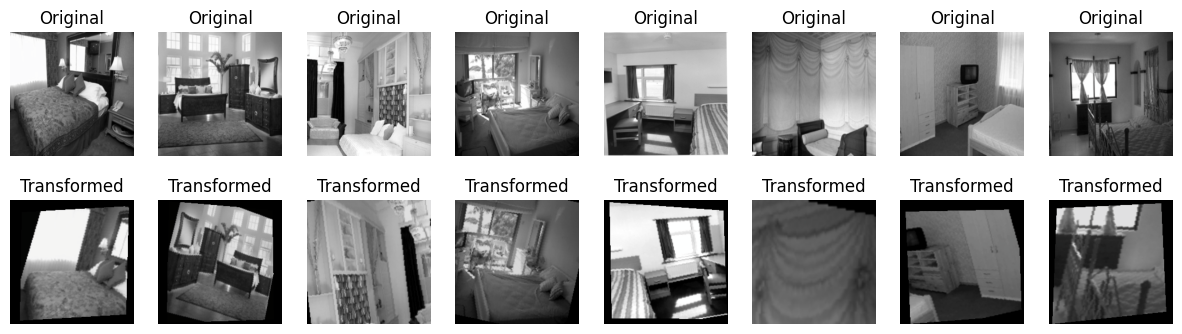

In [33]:
def duplicateChannel(img):
    img = img.convert('RGB')
    return img 

transform = transforms.Compose([
                transforms.Resize((224,224)),
                #transforms.Lambda(duplicateChannel),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

augmented_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop((224, 224), antialias=True),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        #transforms.Lambda(duplicateChannel),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




from PIL import Image

# Load the dataset with basic transformation
basic_dataset = datasets.ImageFolder(path+'/train', transform=transform)

# Function to load a single raw image from the dataset (as PIL Image)
def load_raw_image(dataset, index):
    path, _ = dataset.imgs[index]
    return Image.open(path).convert('RGB')

# Load several raw images
raw_images = [load_raw_image(basic_dataset, i) for i in range(bsize)]

# Now apply the transformations
basic_images = [transform(image) for image in raw_images]
augmented_images = [augmented_transform(image) for image in raw_images]



def imshow(img_tensor):
    img = img_tensor.detach().cpu().numpy()  # Ensure tensor is detached and on CPU
    img = img.transpose((1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
    return img


fig, axs = plt.subplots(2, bsize, figsize=(15, 4))

for i in range(bsize):
    # Display basic transformed image
    axs[0, i].imshow(imshow(basic_images[i]))
    axs[0, i].axis('off')
    axs[0, i].set_title('Original')

    # Display augmented image
    axs[1, i].imshow(imshow(augmented_images[i]))
    axs[1, i].axis('off')
    axs[1, i].set_title('Transformed')

plt.savefig('imgs/data_augmentation.pdf', format='pdf')
plt.show()



### Training Without data augmentation

In [44]:
train_dataset = datasets.ImageFolder(path+'/train', transform=transform)
# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(path+'/test',transform=transform)


train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True, pin_memory=CUDA)
val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)
test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)

In [45]:
vgg16_scene15 = VGG16_SCENE15()
logger = CSVLogger("lightning_logs/", name="vgg16_scene15")

trainer = Trainer(max_epochs=10, accelerator="gpu", benchmark=True, logger=logger)
trainer.fit(vgg16_scene15, train_loader, val_loader)
trainer.test(vgg16_scene15,test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | vgg16     | VGG                | 134 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.288   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8324958086013794
        test_loss           0.5070845484733582
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5070845484733582, 'test_accuracy': 0.8324958086013794}]

### Training With data augmentation

In [48]:
train_dataset = datasets.ImageFolder(path+'/train', transform=augmented_transform)
# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(path+'/test',transform=transform)


train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True, pin_memory=CUDA)
val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)
test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)

In [49]:
vgg16_scene15_aug = VGG16_SCENE15()
logger = CSVLogger("lightning_logs/", name="vgg16_scene15_aug")

trainer = Trainer(max_epochs=10, accelerator="gpu", benchmark=True, logger=logger)
trainer.fit(vgg16_scene15_aug, train_loader, val_loader)
trainer.test(vgg16_scene15_aug,test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | vgg16     | VGG                | 134 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.288   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8777219653129578
        test_loss           0.3812713325023651
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3812713325023651, 'test_accuracy': 0.8777219653129578}]

### Comparison: Data Augmentation vs No Data Augmentation

In [ ]:
import pandas as pd

# Load the CSV files into dataframes
no_aug_df = pd.read_csv('lightning_logs/vgg16_scene15/version_0/metrics.csv')
aug_df = pd.read_csv('lightning_logs/vgg16_scene15_aug/version_0/metrics.csv')

# Extract the relevant data for plotting
# For the datasets without NaN values in train_accuracy and train_loss
no_aug_train = no_aug_df[no_aug_df['train_accuracy'].notnull()]
aug_train = aug_df[aug_df['train_accuracy'].notnull()]

# For the datasets without NaN values in val_accuracy and val_loss
no_aug_val = no_aug_df[no_aug_df['val_accuracy'].notnull()]
aug_val = aug_df[aug_df['val_accuracy'].notnull()]

no_aug_test_accuracy = no_aug_df['test_accuracy'].dropna().iloc[-1]
aug_test_accuracy = aug_df['test_accuracy'].dropna().iloc[-1]



# Creating a figure with subplots for all three visualizations in a tight layout
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

# Plot 1: Train Loss and Validation Loss
axs[0].plot(no_aug_train['epoch'], no_aug_train['train_loss'], label='No Aug - Train Loss', color='blue')
axs[0].plot(no_aug_val['epoch'], no_aug_val['val_loss'], label='No Aug - Val Loss', color='lightblue')
axs[0].plot(aug_train['epoch'], aug_train['train_loss'], label='With Aug - Train Loss', color='green')
axs[0].plot(aug_val['epoch'], aug_val['val_loss'], label='With Aug - Val Loss', color='lightgreen')
axs[0].set_title('Train Loss and Validation Loss (With and Without Data Augmentation)')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Train Accuracy and Validation Accuracy
axs[1].plot(no_aug_train['epoch'], no_aug_train['train_accuracy'], label='No Aug - Train Accuracy', color='blue')
axs[1].plot(no_aug_val['epoch'], no_aug_val['val_accuracy'], label='No Aug - Val Accuracy', color='lightblue')
axs[1].plot(aug_train['epoch'], aug_train['train_accuracy'], label='With Aug - Train Accuracy', color='green')
axs[1].plot(aug_val['epoch'], aug_val['val_accuracy'], label='With Aug - Val Accuracy', color='lightgreen')
axs[1].set_title('Train Accuracy and Validation Accuracy (With and Without Data Augmentation)')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

# Plot 3: Test Accuracy Histogram
axs[2].bar(['No Data Augmentation', 'With Data Augmentation'], [no_aug_test_accuracy, aug_test_accuracy], color=['blue', 'green'])
axs[2].set_title('Test Accuracy Comparison')
axs[2].set_ylabel('Test Accuracy')
axs[2].set_ylim(0, 1)
axs[2].grid(axis='y')

# Adjust layout
plt.tight_layout()
plt.show()


## VGG-16 vs FROZEN VGG-16

### VGG-16 fitted on 15 scene with frozen layers (except last one)

In [ ]:
import torch
import torchvision
import torch.nn as nn
import pytorch_lightning as pl
from torchmetrics import Accuracy
import torch.optim as optim

class VGG16_SCENE15_FREEZE(pl.LightningModule):
    def __init__(self):
        super(VGG16_SCENE15, self).__init__()
        self.vgg16 = torchvision.models.vgg16(pretrained=True)

        # Freeze all layers of the model
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # Replace the last layer of the classifier and unfreeze it
        num_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_features, 15)  # 15 classes for Scene 15
        for param in self.vgg16.classifier[6].parameters():
            param.requires_grad = True

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=15)
           
    def forward(self, x):
        return self.vgg16(x)

    def common_step(self, batch, batch_idx):
        images, labels = batch
        labels_hat = self(images)
        loss = self.criterion(labels_hat, labels)
        acc = self.accuracy(labels_hat, labels)
        return loss, acc, labels_hat
    
    def training_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "train_loss": loss,
                "train_accuracy": acc,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "val_loss": loss,
                "val_accuracy": acc,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )
        
    def test_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "test_loss": loss,
                "test_accuracy": acc,
            },
            prog_bar=True,
        )
        
    def configure_optimizers(self):
        # Only optimize the parameters of the final layer
        optimizer = optim.SGD(self.vgg16.classifier[6].parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
        return optimizer

In [ ]:
train_dataset = datasets.ImageFolder(path+'/train', transform=transform)
# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(path+'/test',transform=transform)


train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True, pin_memory=CUDA)
val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)
test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)

vgg16_scene15_frozen = VGG16_SCENE15_FREEZE()
logger = CSVLogger("lightning_logs/", name="vgg16_scene15_frozen")

trainer = Trainer(max_epochs=10, accelerator="gpu", benchmark=True, logger=logger)
trainer.fit(vgg16_scene15_frozen, train_loader, val_loader)
trainer.test(vgg16_scene15_frozen,test_loader)

### Comparison : Frozen vs Not Frozen VGG

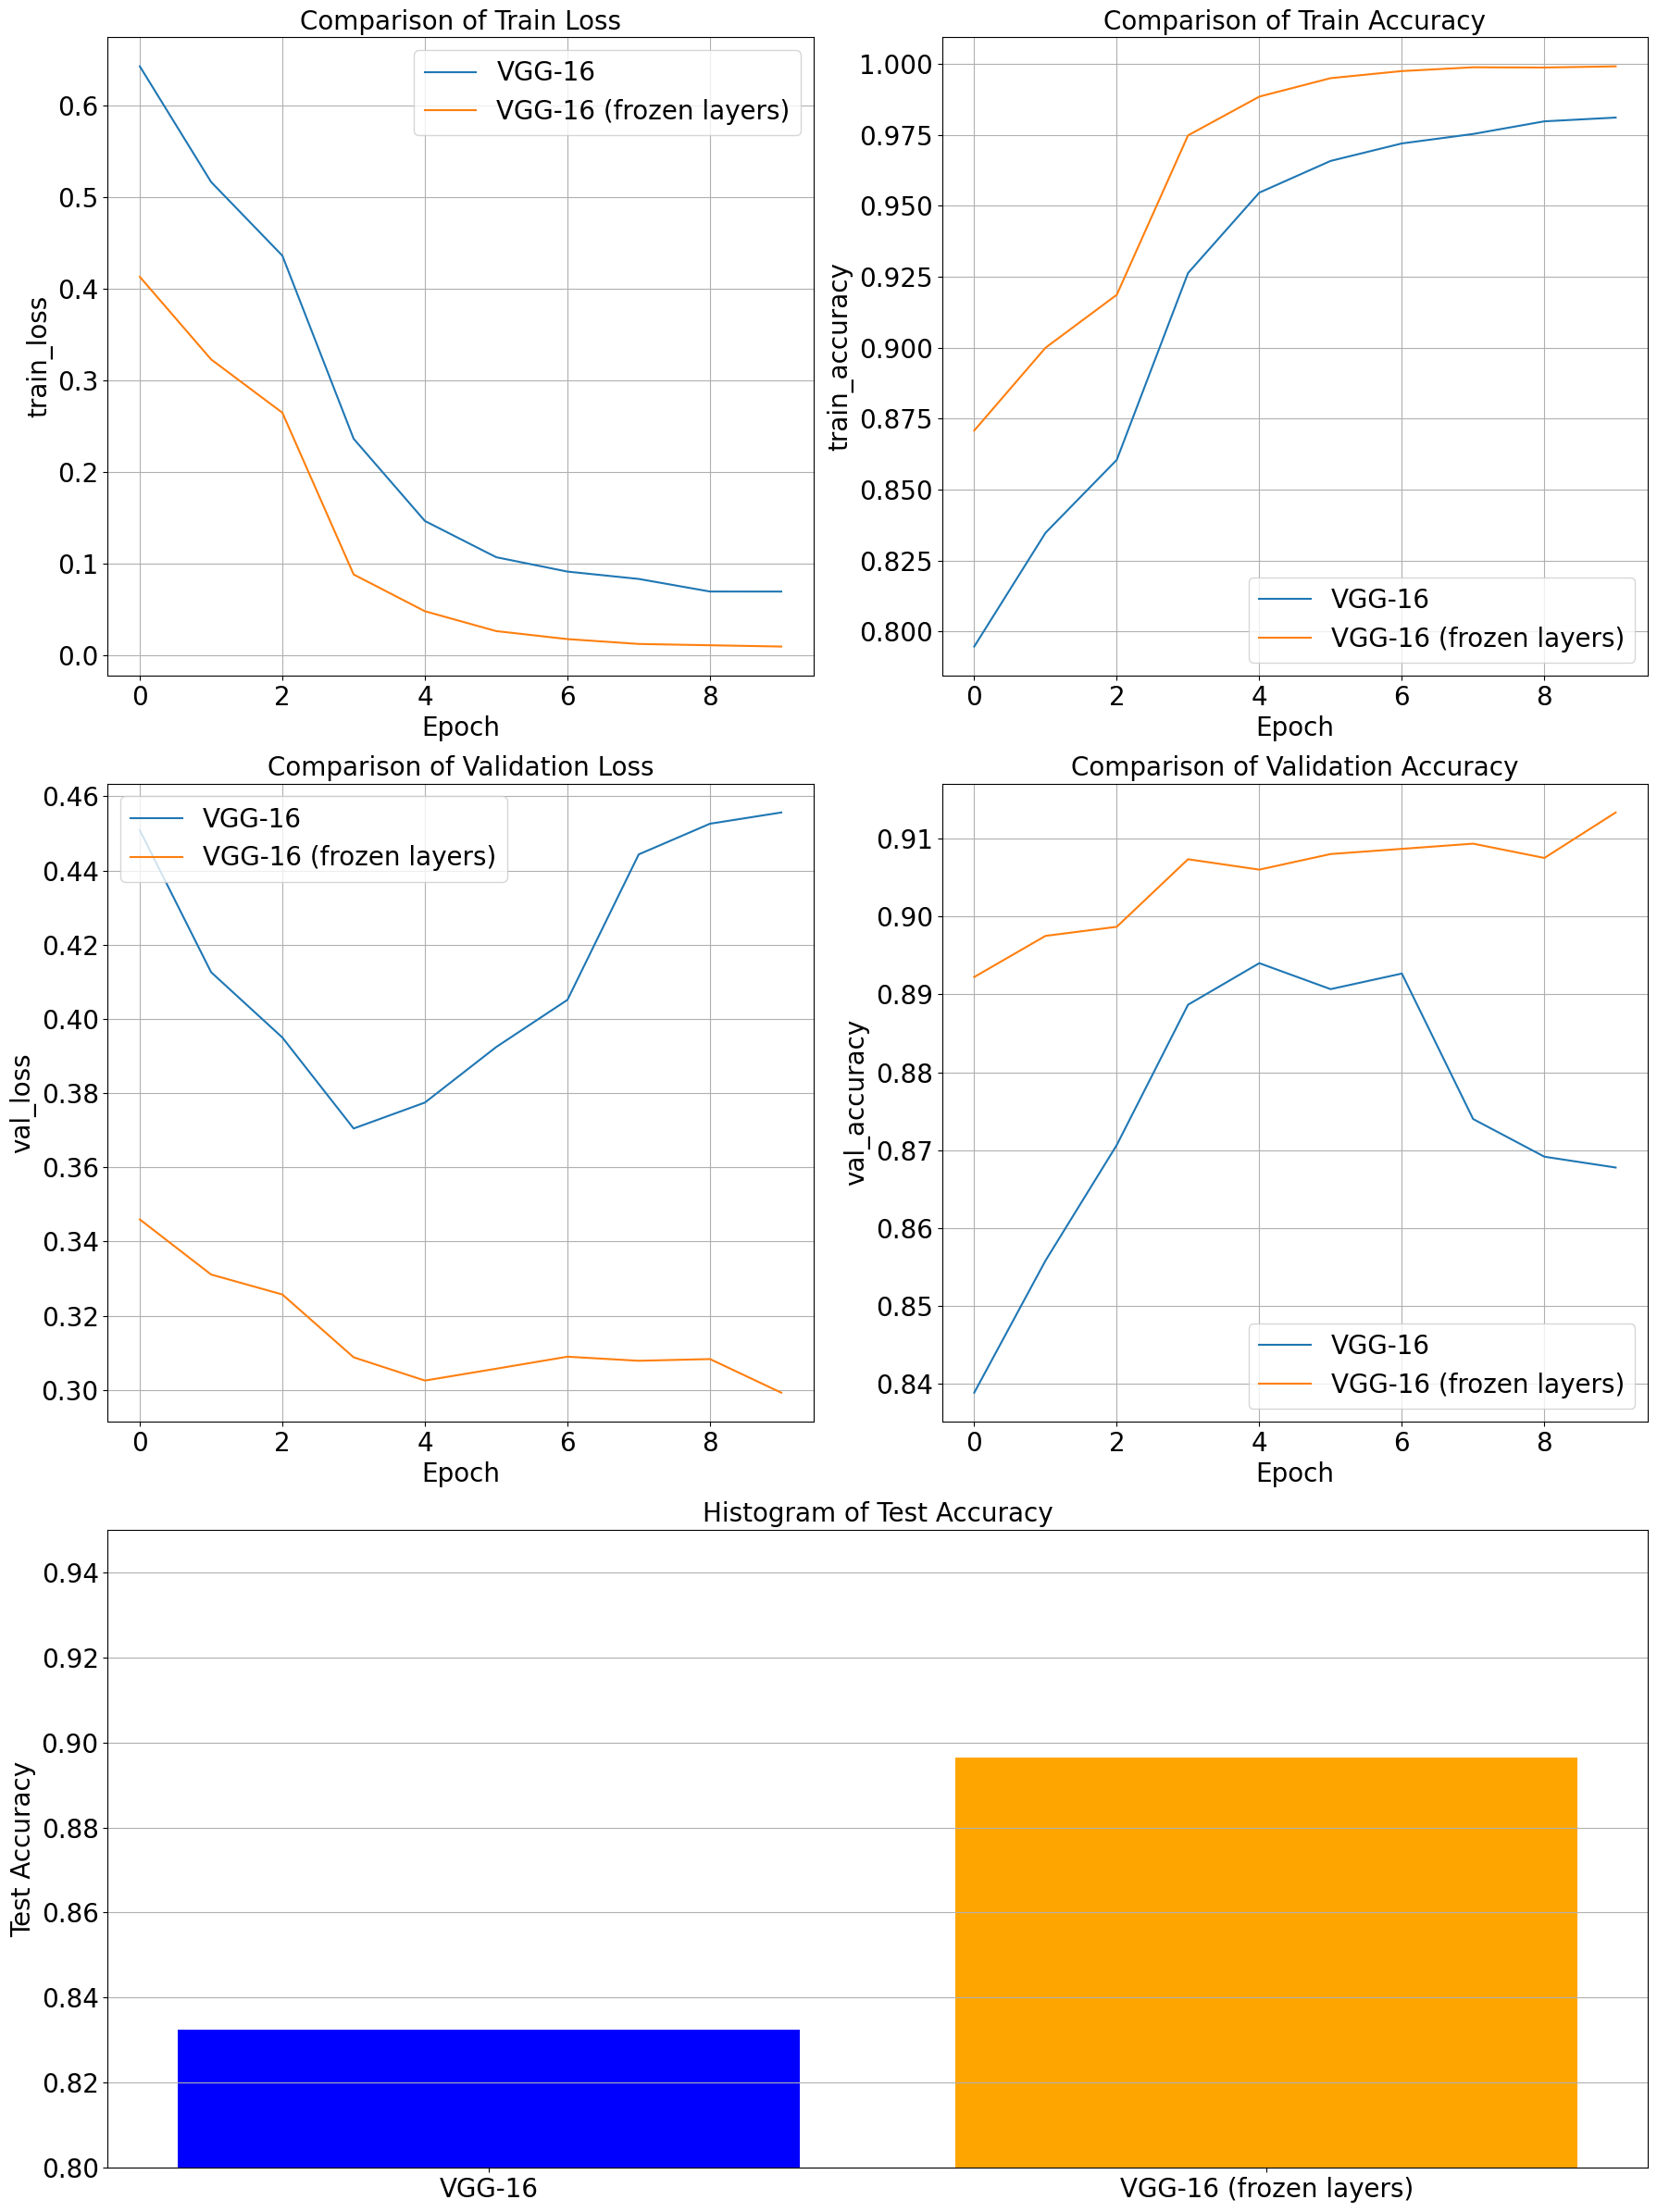

In [121]:
not_frozen_df    = pd.read_csv('lightning_logs/vgg16_scene15/version_0/metrics.csv') 
frozen_df        = pd.read_csv('lightning_logs/vgg16_scene15_frozen/version_0/metrics.csv') 

# Prepare data for plotting
datasets = {
    'VGG-16': not_frozen_df,
    'VGG-16 (frozen layers)': frozen_df,
}

# Setting up the figure and axes for the subplots
fig = plt.figure(figsize=(18, 24))

# Global font size settings
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 20  # Axes label font size
plt.rcParams['xtick.labelsize'] = 20 # X-axis tick label size
plt.rcParams['ytick.labelsize'] = 20 # Y-axis tick label size
plt.rcParams['legend.fontsize'] = 20 # Legend font size

# Create subplots for the first four plots
ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 0))
ax4 = plt.subplot2grid((3, 2), (1, 1))

# Create a subplot for the test accuracy histogram that spans two columns
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)

# Function to plot on a specific axis
def plot_on_axis(ax, metric, title, smoothing_factor=5):
    for name, df in datasets.items():
        df_train = df[df[metric].notnull()]
        smoothed_data = moving_average(df_train[metric], smoothing_factor)
        ax.plot(df_train['epoch'], smoothed_data, label=name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# 1. Comparing train loss
plot_on_axis(ax1, 'train_loss', 'Comparison of Train Loss')

# 2. Comparing train accuracy
plot_on_axis(ax2, 'train_accuracy', 'Comparison of Train Accuracy')

# 3. Comparing validation loss
plot_on_axis(ax3, 'val_loss', 'Comparison of Validation Loss')

# 4. Comparing validation accuracy
plot_on_axis(ax4, 'val_accuracy', 'Comparison of Validation Accuracy')

# 5. Histogram of test accuracy
test_accuracies = [df['test_accuracy'].dropna().iloc[-1] for df in datasets.values()]
ax5.bar(datasets.keys(), test_accuracies, color=['blue', 'orange'])
ax5.set_ylabel('Test Accuracy')
ax5.set_title('Histogram of Test Accuracy')
ax5.set_ylim(0.8, 0.95)
ax5.grid(axis='y')

# Adjust layout
plt.tight_layout()
plt.savefig("frozen_vs_nonfrozen.pdf")
plt.show()


## Experimention with other models

### AlexNet

In [90]:
import torch.nn as nn
import torchvision.models as models
import pytorch_lightning as pl
from torchmetrics import Accuracy
import torch.optim as optim

class AlexNet_SCENE15(pl.LightningModule):
    def __init__(self):
        super(AlexNet_SCENE15, self).__init__()
        self.alexnet = models.alexnet(pretrained=True)

        # Replace the classifier in AlexNet for the Scene 15 dataset
        num_features = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Linear(num_features, 15)  # 15 classes for Scene 15

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=15)
    
    def forward(self, x):
        # In AlexNet, there's only one output
        return self.alexnet(x)

    def common_step(self, batch, batch_idx):
        images, labels = batch
        labels_hat = self(images)
        loss = self.criterion(labels_hat, labels)
        acc = self.accuracy(labels_hat, labels)
        return loss, acc, labels_hat
    
    def training_step(self, batch, batch_idx):
        loss, acc, _ = self.common_step(batch, batch_idx)
        self.log_dict({"train_loss": loss, "train_accuracy": acc}, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc, _ = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "val_loss": loss,
                "val_accuracy": acc,
            },
            on_step=False,
            on_epoch=True,
            prog_bar=True,
        )

    def test_step(self, batch, batch_idx):
        loss, acc, _ = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "test_loss": loss,
                "test_accuracy": acc,
            },
            prog_bar=True,
        )

    def configure_optimizers(self):
        optimizer = optim.SGD(self.alexnet.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
        return optimizer


In [91]:
train_dataset = datasets.ImageFolder(path+'/train', transform=transform)
# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(path+'/test',transform=transform)


train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True, pin_memory=CUDA)
val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)
test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)

In [92]:
vgg19_scene15 = AlexNet_SCENE15()
logger = CSVLogger("lightning_logs/", name="alexnet_scene15")

trainer = Trainer(max_epochs=10, accelerator="gpu", benchmark=True, logger=logger)
trainer.fit(vgg19_scene15, train_loader, val_loader)
trainer.test(vgg19_scene15,test_loader)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\maebo/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:20<00:00, 11.9MB/s] 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | alexnet   | AlexNet            | 57.1 M
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
57.1 M    Trainable params
0         Non-trainable params
57.1 M    Total params
228.261   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8217755556106567
        test_loss           0.6518008708953857
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6518008708953857, 'test_accuracy': 0.8217755556106567}]

### VGG-19

In [71]:
CUDA = torch.cuda.is_available()

class VGG19_SCENE15(pl.LightningModule):
    def __init__(self):
        super(VGG19_SCENE15, self).__init__()
        self.vgg19 = torchvision.models.vgg19(pretrained=True)
        self.vgg19.classifier[6] = nn.Linear(self.vgg19.classifier[6].in_features, 15)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass',num_classes=15)
           
    def forward(self, x):
        return self.vgg19(x)


    def common_step(self, batch, batch_idx):
        images, labels = batch
        labels_hat = self(images)
        loss = self.criterion(labels_hat, labels)
        acc = self.accuracy(labels_hat, labels)
        return loss, acc, labels_hat
    
            
    def training_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "train_loss": loss,
                "train_accuracy": acc,
            },
        on_step=False,
        on_epoch=True,
        prog_bar=True,
        )
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "val_loss": loss,
                "val_accuracy": acc,
            },
        on_step=False,
        on_epoch=True,
        prog_bar=True,
        )
        
    
    def test_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "test_loss": loss,
                "test_accuracy": acc,
            },
            prog_bar=True,
        )
        

    def configure_optimizers(self):
        optimizer = optim.SGD(self.vgg19.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
        return optimizer


In [82]:
train_dataset = datasets.ImageFolder(path+'/train', transform=transform)
# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(path+'/test',transform=transform)


train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True, pin_memory=CUDA)
val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)
test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)

In [83]:
vgg19_scene15 = VGG19_SCENE15()
logger = CSVLogger("lightning_logs/", name="vgg19_scene15")

trainer = Trainer(max_epochs=10, accelerator="gpu", benchmark=True, logger=logger)
trainer.fit(vgg19_scene15, train_loader, val_loader)
trainer.test(vgg19_scene15,test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | vgg19     | VGG                | 139 M 
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
139 M     Trainable params
0         Non-trainable params
139 M     Total params
558.527   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8770519495010376
        test_loss           0.4711601138114929
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4711601138114929, 'test_accuracy': 0.8770519495010376}]

### ResNet50

In [74]:
class ResNet50_SCENE15(pl.LightningModule):
    def __init__(self):
        super(ResNet50_SCENE15, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)

        # Modify the last fully connected layer
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_features, 15)  # 15 classes for Scene 15

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=15)
    
    def forward(self, x):
        return self.resnet50(x)

    def common_step(self, batch, batch_idx):
        images, labels = batch
        labels_hat = self(images)
        loss = self.criterion(labels_hat, labels)
        acc = self.accuracy(labels_hat, labels)
        return loss, acc, labels_hat
    
            
    def training_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "train_loss": loss,
                "train_accuracy": acc,
            },
        on_step=False,
        on_epoch=True,
        prog_bar=True,
        )
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "val_loss": loss,
                "val_accuracy": acc,
            },
        on_step=False,
        on_epoch=True,
        prog_bar=True,
        )
        
    
    def test_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "test_loss": loss,
                "test_accuracy": acc,
            },
            prog_bar=True,
        )
        

    def configure_optimizers(self):
        optimizer = optim.SGD(self.resnet50.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
        return optimizer


In [80]:
train_dataset = datasets.ImageFolder(path+'/train', transform=transform)
# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(path+'/test',transform=transform)


train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True, pin_memory=CUDA)
val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)
test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)

In [81]:
resnet50_scene15 = ResNet50_SCENE15()
logger = CSVLogger("lightning_logs/", name="resnet50_scene15")

trainer = Trainer(max_epochs=10, accelerator="gpu", benchmark=True, logger=logger)
trainer.fit(resnet50_scene15, train_loader, val_loader)
trainer.test(resnet50_scene15,test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | resnet50  | ResNet             | 23.5 M
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.155    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9105527400970459
        test_loss           0.2999952435493469
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2999952435493469, 'test_accuracy': 0.9105527400970459}]

### ResNet152

In [77]:
class ResNet152_SCENE15(pl.LightningModule):
    def __init__(self):
        super(ResNet152_SCENE15, self).__init__()
        self.resnet152 = models.resnet152(pretrained=True)

        # Modify the last fully connected layer
        num_features = self.resnet152.fc.in_features
        self.resnet152.fc = nn.Linear(num_features, 15)  # 15 classes for Scene 15

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=15)
    
    def forward(self, x):
        return self.resnet152(x)

    def common_step(self, batch, batch_idx):
        images, labels = batch
        labels_hat = self(images)
        loss = self.criterion(labels_hat, labels)
        acc = self.accuracy(labels_hat, labels)
        return loss, acc, labels_hat
    
            
    def training_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "train_loss": loss,
                "train_accuracy": acc,
            },
        on_step=False,
        on_epoch=True,
        prog_bar=True,
        )
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "val_loss": loss,
                "val_accuracy": acc,
            },
        on_step=False,
        on_epoch=True,
        prog_bar=True,
        )
        
    
    def test_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "test_loss": loss,
                "test_accuracy": acc,
            },
            prog_bar=True,
        )
        

    def configure_optimizers(self):
        optimizer = optim.SGD(self.resnet152.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
        return optimizer


In [84]:
train_dataset = datasets.ImageFolder(path+'/train', transform=transform)
# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(path+'/test',transform=transform)


train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True, pin_memory=CUDA)
val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)
test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)

In [85]:
resnet152_scene15 = ResNet152_SCENE15()
logger = CSVLogger("lightning_logs/", name="resnet152_scene15")

trainer = Trainer(max_epochs=10, accelerator="gpu", benchmark=True, logger=logger)
trainer.fit(resnet152_scene15, train_loader, val_loader)
trainer.test(resnet152_scene15,test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | resnet152 | ResNet             | 58.2 M
1 | criterion | CrossEntropyLoss   | 0     
2 | accuracy  | MulticlassAccuracy | 0     
-------------------------------------------------
58.2 M    Trainable params
0         Non-trainable params
58.2 M    Total params
232.698   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9286432266235352
        test_loss           0.2274274379014969
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2274274379014969, 'test_accuracy': 0.9286432266235352}]

### Inception_V3

In [86]:
class Inception_SCENE15(pl.LightningModule):
    def __init__(self):
        super(Inception_SCENE15, self).__init__()
        self.inception_v3 = models.inception_v3(pretrained=True, aux_logits=True)

        num_features = self.inception_v3.fc.in_features
        self.inception_v3.fc = nn.Linear(num_features, 15)  # 15 classes for Scene 15
        
        aux_num_features = self.inception_v3.AuxLogits.fc.in_features
        self.inception_v3.AuxLogits.fc = nn.Linear(aux_num_features, 15)
        
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=15)
    
    def forward(self, x):
        if self.training:
            # In training mode, Inception returns both main and auxiliary outputs
            main_output, aux_output = self.inception_v3(x)
            return main_output, aux_output
        else:
            # In evaluation mode, Inception returns only the main output
            return self.inception_v3(x)


    def common_step(self, batch, batch_idx):
        images, labels = batch
        labels_hat = self(images)
        loss = self.criterion(labels_hat, labels)
        acc = self.accuracy(labels_hat, labels)
        return loss, acc, labels_hat
    
            
    def training_step(self, batch, batch_idx):
        images, labels = batch
        main_output, aux_output = self(images)  # Get both outputs
        main_loss = self.criterion(main_output, labels)
        aux_loss = self.criterion(aux_output, labels)
        total_loss = main_loss + 0.4 * aux_loss  # Weighted sum of the main and auxiliary losses
        acc = self.accuracy(main_output, labels)
        self.log_dict({"train_loss": total_loss, "train_accuracy": acc}, on_step=False, on_epoch=True, prog_bar=True)
        return total_loss
    
    
    def validation_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "val_loss": loss,
                "val_accuracy": acc,
            },
        on_step=False,
        on_epoch=True,
        prog_bar=True,
        )
        
    
    def test_step(self, batch, batch_idx):
        loss, acc, y = self.common_step(batch, batch_idx)
        self.log_dict(
            {
                "test_loss": loss,
                "test_accuracy": acc,
            },
            prog_bar=True,
        )
        

    def configure_optimizers(self):
        optimizer = optim.SGD(self.inception_v3.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
        return optimizer


In [87]:
transform_inception = transforms.Compose([
                transforms.Resize((299,299)),
                transforms.Lambda(duplicateChannel),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

train_dataset = datasets.ImageFolder(path+'/train', transform=transform_inception)
# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(path+'/test',transform=transform)


train_loader = DataLoader(train_dataset, batch_size=bsize, shuffle=True, pin_memory=CUDA)
val_loader = DataLoader(val_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)
test_loader = DataLoader(test_dataset, batch_size=bsize, shuffle=False, pin_memory=CUDA)

In [88]:
inception_scene15 = Inception_SCENE15()
logger = CSVLogger("lightning_logs/", name="inception_v3_scene15")

trainer = Trainer(max_epochs=10, accelerator="gpu", benchmark=True, logger=logger)
trainer.fit(inception_scene15, train_loader, val_loader)
trainer.test(inception_scene15,test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params
----------------------------------------------------
0 | inception_v3 | Inception3         | 24.4 M
1 | criterion    | CrossEntropyLoss   | 0     
2 | accuracy     | MulticlassAccuracy | 0     
----------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.542    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.880066990852356
        test_loss           0.5380421876907349
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5380421876907349, 'test_accuracy': 0.880066990852356}]

### Comparison

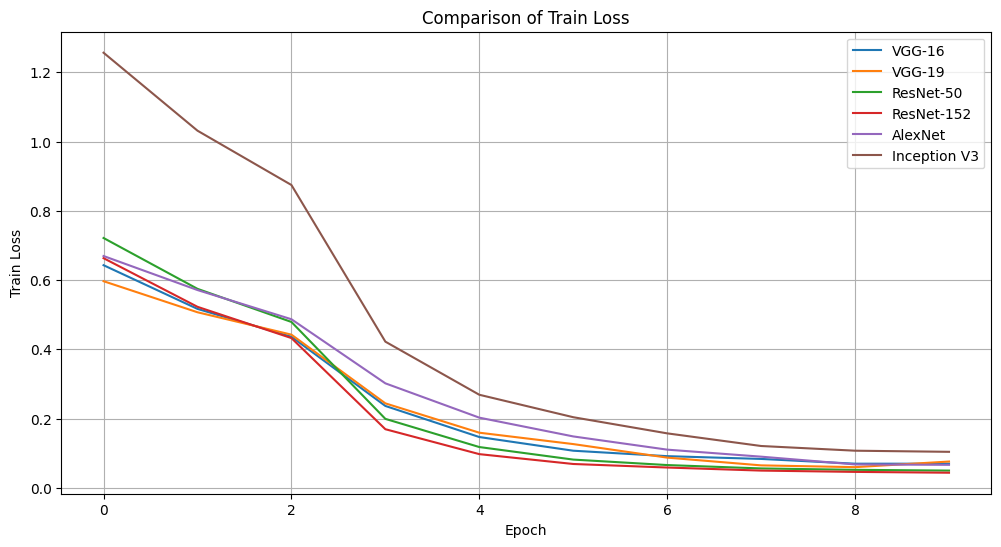

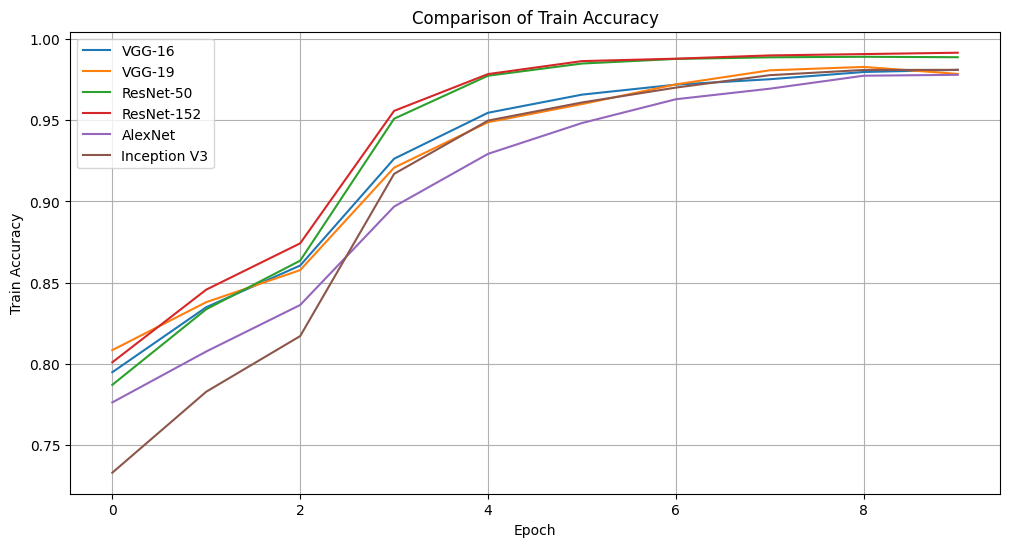

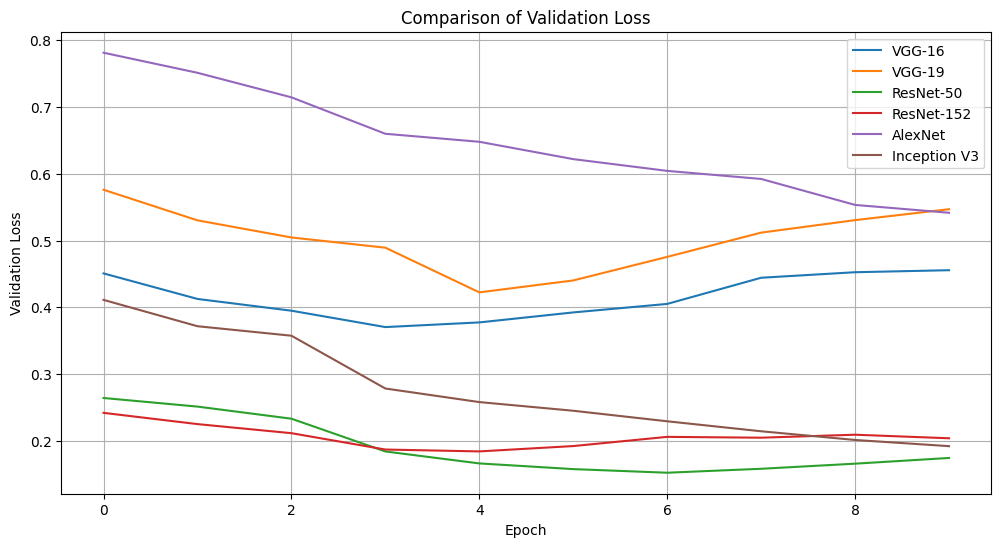

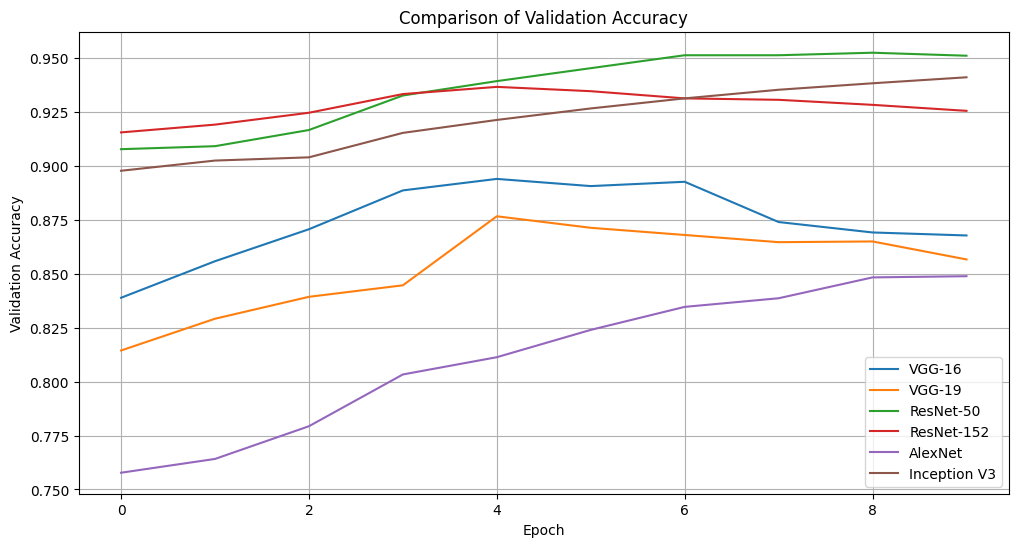

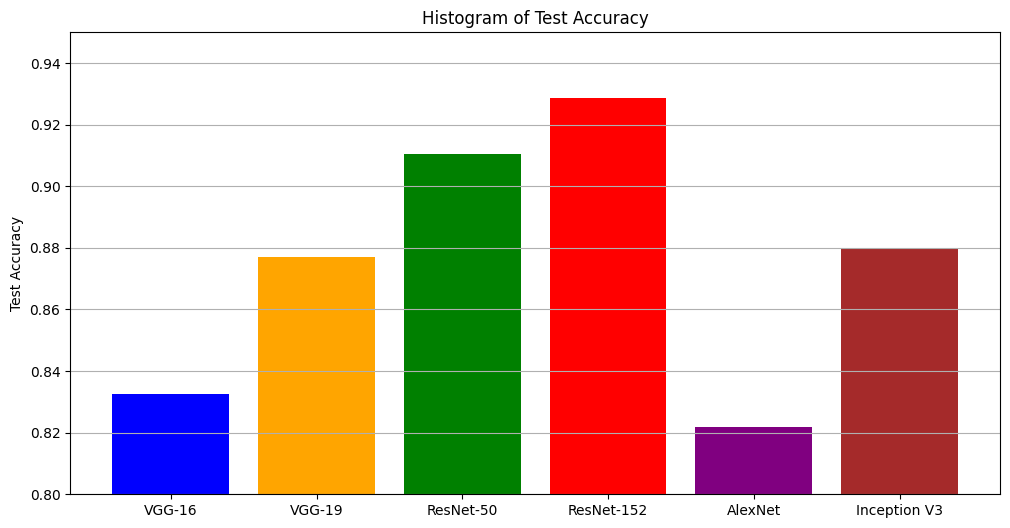

In [106]:
# Load the CSV files
vgg16_res = pd.read_csv('lightning_logs/vgg16_scene15/version_0/metrics.csv')
vgg19_res = pd.read_csv('lightning_logs/vgg19_scene15/version_0/metrics.csv')
resnet50_res = pd.read_csv('lightning_logs/resnet50_scene15/version_0/metrics.csv')
resnet152_res = pd.read_csv('lightning_logs/resnet152_scene15/version_0/metrics.csv')
alexnet_res = pd.read_csv('lightning_logs/alexnet_scene15/version_0/metrics.csv')
inception_v3_res = pd.read_csv('lightning_logs/inception_v3_scene15/version_0/metrics.csv')

# Prepare data for plotting
datasets = {
    'VGG-16': vgg16_res,
    'VGG-19': vgg19_res,
    'ResNet-50': resnet50_res,
    'ResNet-152': resnet152_res,
    'AlexNet': alexnet_res,
    'Inception V3': inception_v3_res
}

def moving_average(data, window_size):
    """Smooth data by applying a moving average."""
    return data.rolling(window=window_size, min_periods=1, center=True).mean()

def plot_comparison(metric, ylabel, title, smoothing_factor=5):
    plt.figure(figsize=(12, 6))
    for name, df in datasets.items():
        df_train = df[df[metric].notnull()]
        smoothed_data = moving_average(df_train[metric], smoothing_factor)
        plt.plot(df_train['epoch'], smoothed_data, label=name)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# 1. Comparing train loss
plot_comparison('train_loss', 'Train Loss', 'Comparison of Train Loss')

# 2. Comparing train accuracy
plot_comparison('train_accuracy', 'Train Accuracy', 'Comparison of Train Accuracy')

# 3. Comparing validation loss
plot_comparison('val_loss', 'Validation Loss', 'Comparison of Validation Loss')

# 4. Comparing validation accuracy
plot_comparison('val_accuracy', 'Validation Accuracy', 'Comparison of Validation Accuracy')

# 5. Histogram of test accuracy
plt.figure(figsize=(12, 6))
test_accuracies = [df['test_accuracy'].dropna().iloc[-1] for df in datasets.values()]
plt.bar(datasets.keys(), test_accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.ylabel('Test Accuracy')
plt.title('Histogram of Test Accuracy')
plt.ylim(0.8,0.95)
plt.grid(axis='y')
plt.show()


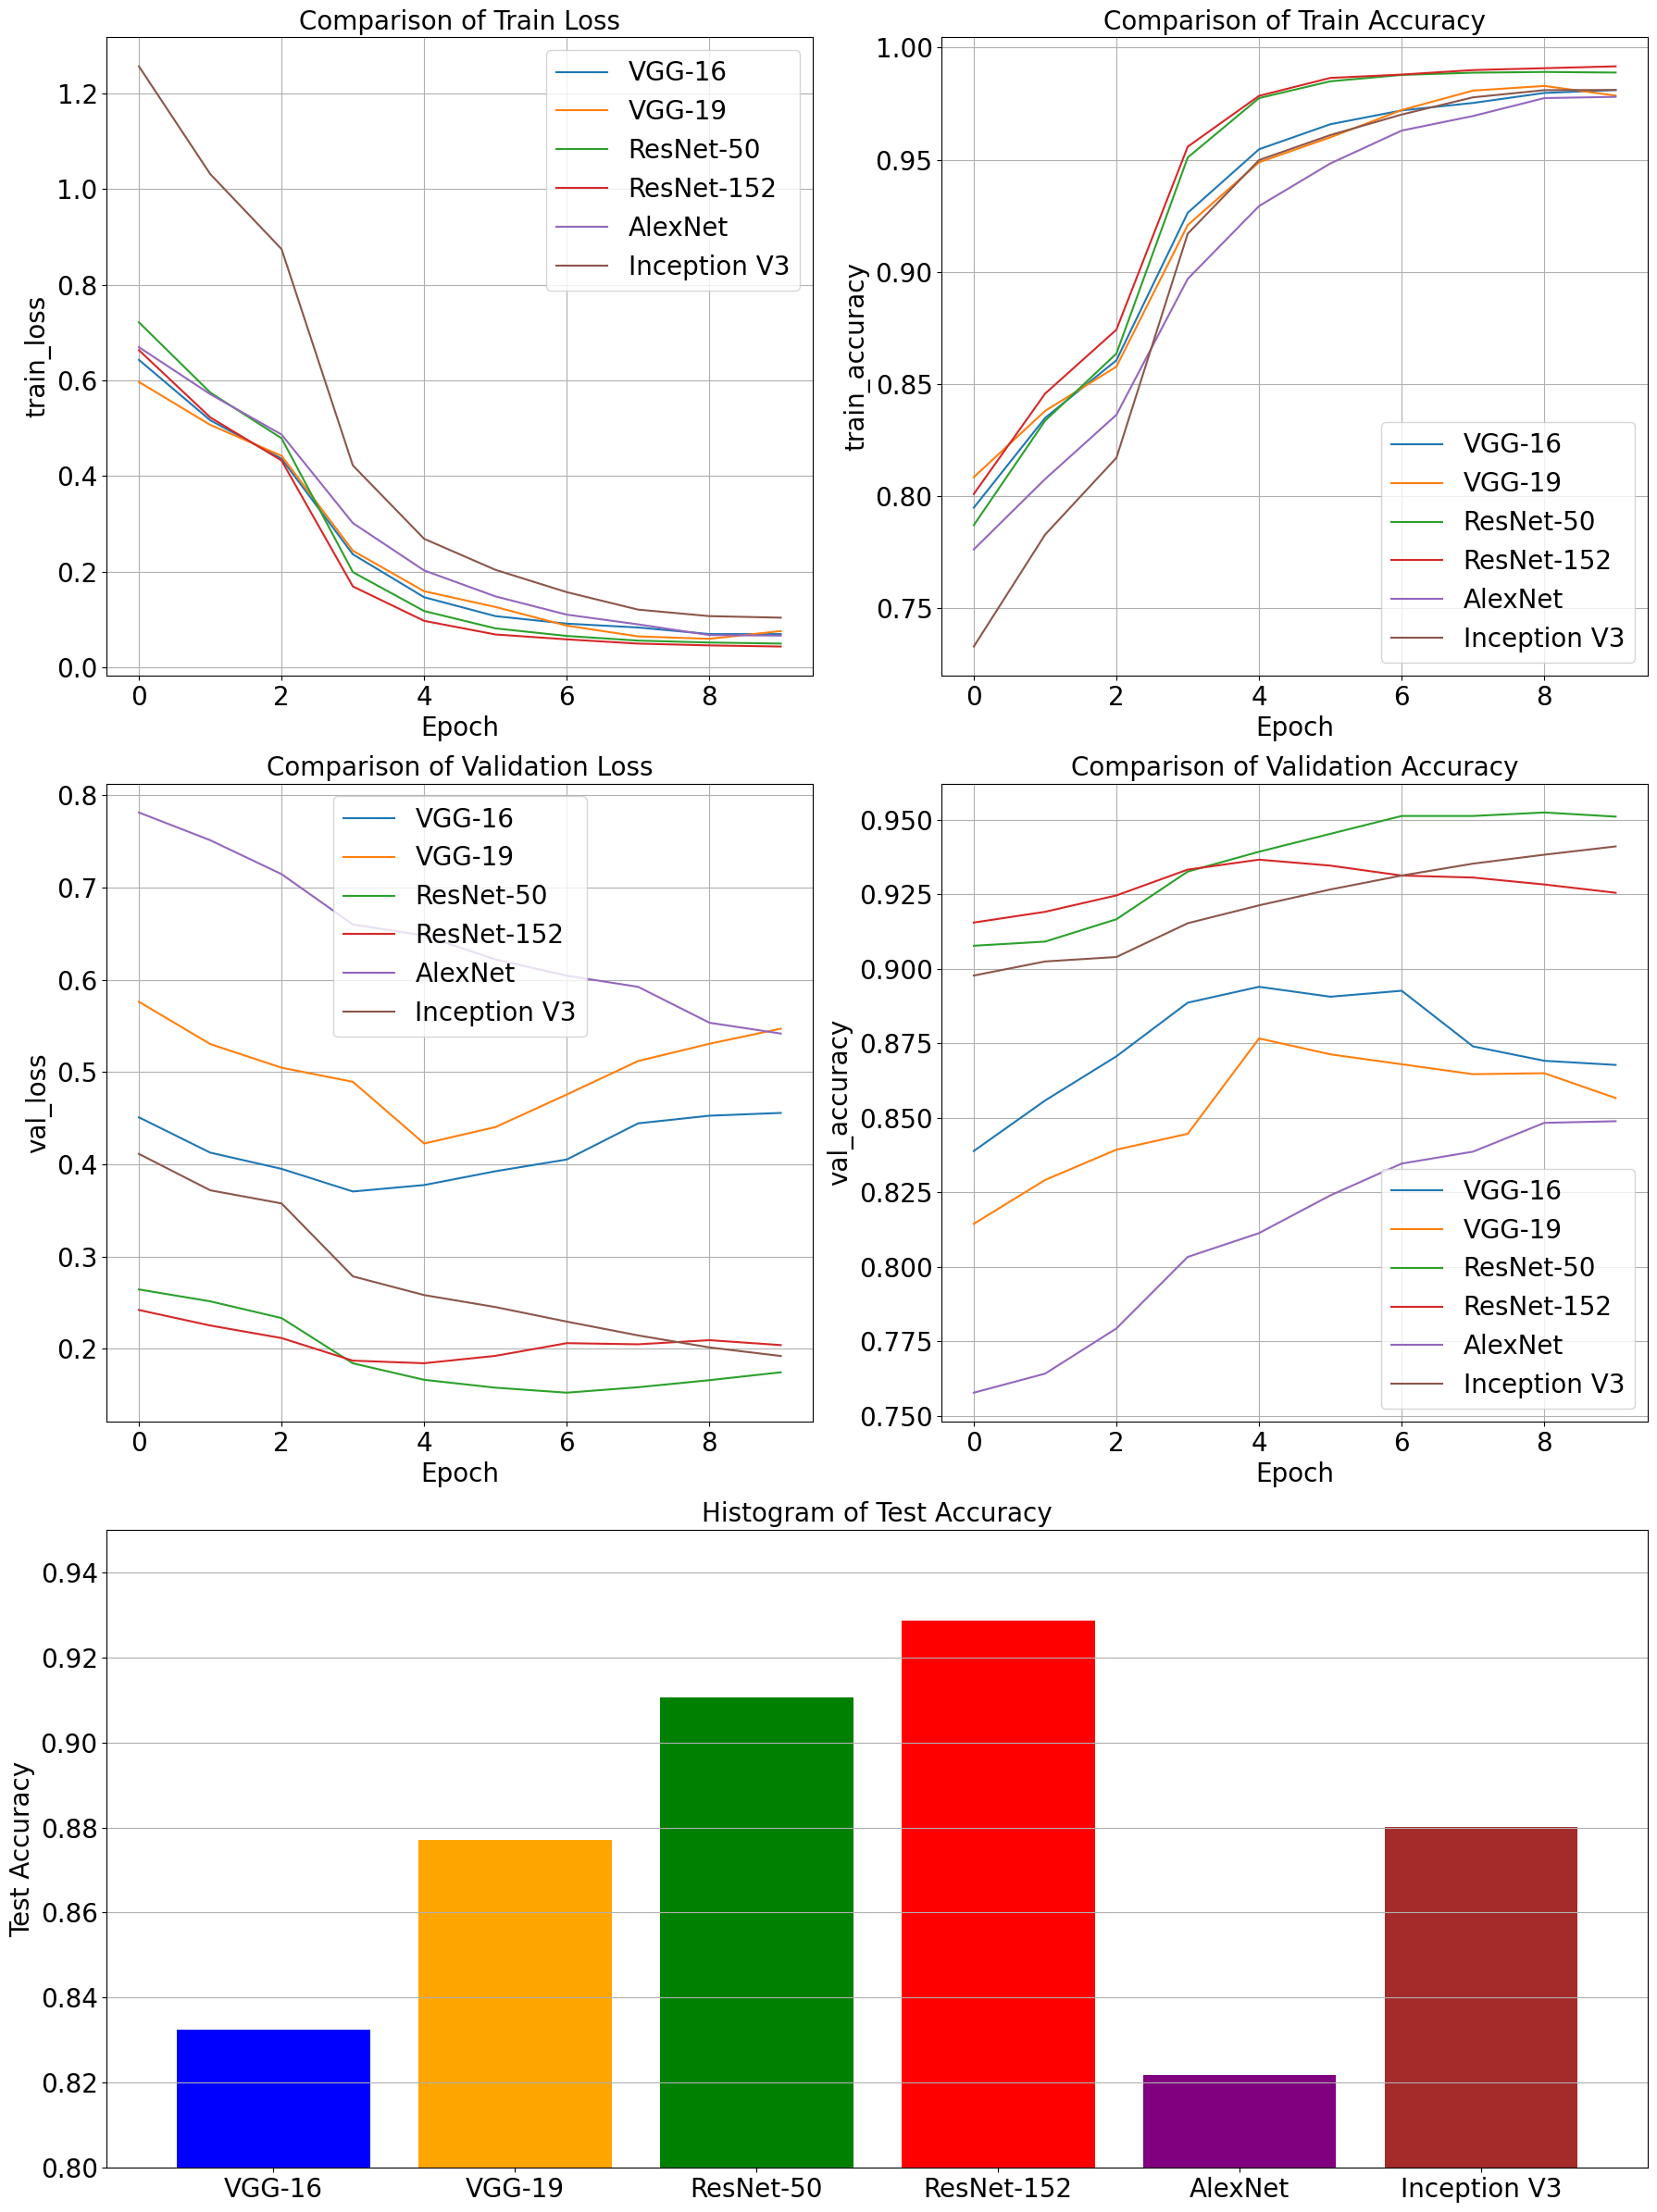

In [111]:
import matplotlib.pyplot as plt

# Setting up the figure and axes for the subplots
fig = plt.figure(figsize=(18, 24))

# Global font size settings
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 20  # Axes label font size
plt.rcParams['xtick.labelsize'] = 20 # X-axis tick label size
plt.rcParams['ytick.labelsize'] = 20 # Y-axis tick label size
plt.rcParams['legend.fontsize'] = 20 # Legend font size

# Create subplots for the first four plots
ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 0))
ax4 = plt.subplot2grid((3, 2), (1, 1))

# Create a subplot for the test accuracy histogram that spans two columns
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)

# Function to plot on a specific axis
def plot_on_axis(ax, metric, title, smoothing_factor=5):
    for name, df in datasets.items():
        df_train = df[df[metric].notnull()]
        smoothed_data = moving_average(df_train[metric], smoothing_factor)
        ax.plot(df_train['epoch'], smoothed_data, label=name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

# 1. Comparing train loss
plot_on_axis(ax1, 'train_loss', 'Comparison of Train Loss')

# 2. Comparing train accuracy
plot_on_axis(ax2, 'train_accuracy', 'Comparison of Train Accuracy')

# 3. Comparing validation loss
plot_on_axis(ax3, 'val_loss', 'Comparison of Validation Loss')

# 4. Comparing validation accuracy
plot_on_axis(ax4, 'val_accuracy', 'Comparison of Validation Accuracy')

# 5. Histogram of test accuracy
test_accuracies = [df['test_accuracy'].dropna().iloc[-1] for df in datasets.values()]
ax5.bar(datasets.keys(), test_accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
ax5.set_ylabel('Test Accuracy')
ax5.set_title('Histogram of Test Accuracy')
ax5.set_ylim(0.8, 0.95)
ax5.grid(axis='y')

# Adjust layout
plt.tight_layout()
plt.savefig("other_models_performance_comparison.pdf")
plt.show()
